I use this cell to install needed packages in my environment under the name new_py

In [ ]:
!pip install scipy

### Importing all the used libraries in the project

In [1]:
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
import torch.nn as nn
import math
import torch.optim as optim
from scipy.integrate import odeint, quad

Define the true voltage function (Square Wave Function in the range $$[-2\pi , 2\pi]$$

In [2]:
def true_V(t):
    if (t % 2) < 1:
        return 2*math.pi
    else:
        return -2*math.pi

Generate synthetic dataset based on the true voltage function then converting the data to PyTorch tensors

In [48]:
time_steps = torch.linspace(0, 10, 500).reshape(-1, 1)
V_train = np.array([true_V(t) for t in time_steps])  # True voltage values for training

In [49]:
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).unsqueeze(1)  # Shape [500, 1]
V_train_tensor = torch.tensor(V_train, dtype=torch.float32).unsqueeze(1)  # Shape [500, 1]

### Hyperbolic Tangent function where the outputs range is (-1, 1)
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

In [5]:
def hyper_tangent(x):  
        return torch.tanh(x)

We start creating our Neural Network model to get out  Voltage function V(t)

In [50]:
class VoltagePredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(VoltagePredictor, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        # Combine all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
        self.init_weights()

    def init_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                # Random weight and bias = .normal_ / Constant weight and bias = _constant
                nn.init.normal_(layer.weight, mean=0, std=1)
                nn.init.normal_(layer.bias, mean=0, std=1)
                # nn.init.constant_(layer.weight, 100)
                # nn.init.constant_(layer.bias, 100)
    
    def forward(self, x):
        for layer in self.model[:-1]:  # Exclude the last layer for now
            x = torch.tanh(layer(x))  # Use arctan activation function
        x = self.model[-1](x)  # Output layer
        return x

    def get_output(self, time):
        """Get neural network output for a given time input."""
        time_tensor = torch.tensor([[time]], dtype=torch.float32)
        with torch.no_grad():
            return self(time_tensor).item()

In [52]:
# Parameters
input_size = 1
hidden_sizes = [20, 20, 20, 20, 20]  # Example with three hidden layers of size 25
output_size = 1
n_pop = 10

def init_pop(size, input_size, hidden_sizes, output_size):
    return [VoltagePredictor(input_size, hidden_sizes, output_size) for _ in range(size)]

# Initialize population
pop = init_pop(n_pop, input_size, hidden_sizes, output_size)

# Simulation time data
# time_steps = torch.linspace(0, 10, 500).reshape(-1, 1)  # Simulating over time steps

Text(0.5, 1.0, 'Hyperbolic Tangent function when passing time steps')

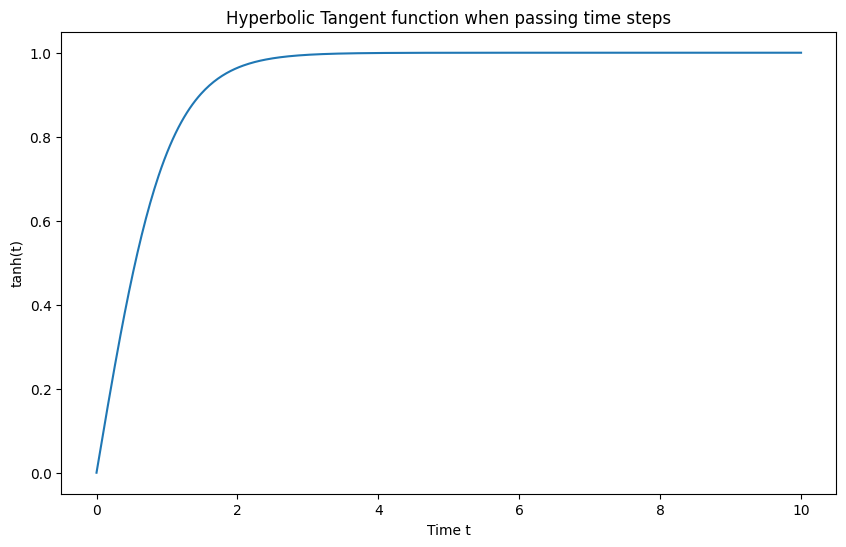

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(time_steps, hyper_tangent(time_steps))
plt.xlabel('Time t')
plt.ylabel('tanh(t)')
plt.title('Hyperbolic Tangent function when passing time steps')

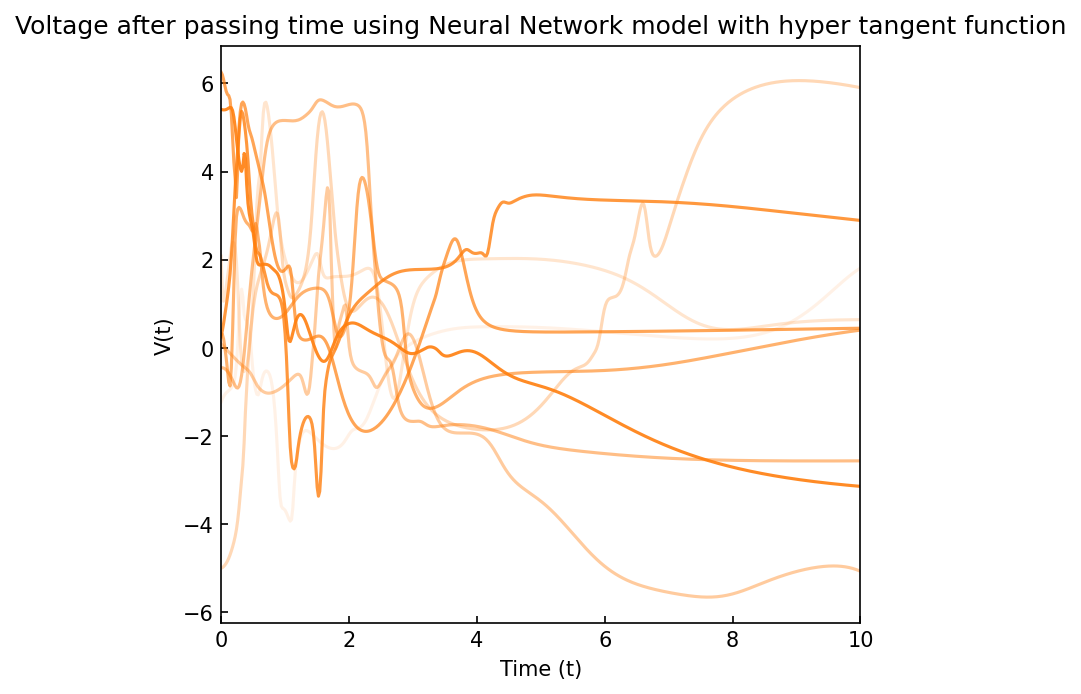

In [54]:
fig, ax = plt.subplots(figsize=(5.5, 5), dpi=150, facecolor='white')
norm = Normalize(vmin=1, vmax=n_pop)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

# Plot each network's output using a color from the viridis colormap
for i, net in enumerate(pop):
    with torch.no_grad():
        A_t = net(time_steps)
        ax.plot(t_train, A_t, label=f'Pop {i+1}', color='C1', alpha=i/len(pop))
    
ax.set_xlabel('Time (t)')
ax.set_ylabel('V(t)')
ax.set_title('Voltage after passing time using Neural Network model with hyper tangent function')
ax.set_xlim(0,10)
ax.tick_params(direction='in')

### Our User Defined Function is 
$$
V(t) = u(t - 1.2) - u(t - 3.8)
$$

In [56]:
# Define the step function u(t-a)
def u(t, a):
    return torch.where(t < a, torch.tensor(0.0), torch.tensor(1.0))

# # Define the user-defined function as a rectangular pulse
# def user_defined_function(x):
#     return u(x, 1.2) - u(x, 3.8)

def user_defined_function(x):
    pulse_width = 2.0  # Width of each pulse
    period = 5.0       # Period of oscillation
    offset = 0.5       # To center the pulse around the y-axis

    # Create a sequence of pulses based on the periodic nature
    pulses = torch.zeros_like(x)
    for i in range(int((x.max() + 1) // period) + 1):
        start = i * period
        pulses += u(x, start + offset) - u(x, start + pulse_width + offset)
    return pulses

# Function to compute the loss between our NN model output and the user-defined function output
def compute_mse_loss(model, input_tensor, loss_fn):
    model_output = model(input_tensor)
    target_output = user_defined_function(input_tensor)
    loss = loss_fn(model_output, target_output)
    return loss

def compute_sum_difference_loss(model, input_tensor):
    model_output = model(input_tensor)
    target_output = user_defined_function(input_tensor)
    difference = torch.abs(model_output - target_output)
    loss = torch.sum(difference)
    return loss

In [57]:
# Initialize the NN model 
model = VoltagePredictor(input_size, hidden_sizes, output_size)

# Loss function using Mean Square Error Loss
loss_fn = nn.MSELoss()  
loss_value = compute_mse_loss(model, time_steps, loss_fn)
print(f'Loss between the model and user-defined function using MSE: {loss_value.item()}')

# # Loss function using the sum of differeces Loss 
loss_absolute_value = compute_sum_difference_loss(model, time_steps)
print(f'Loss between the model and user-defined function using Sum of Differeces: {loss_absolute_value.item()}')

Loss between the model and user-defined function using MSE: 12.886466026306152
Loss between the model and user-defined function using Sum of Differeces: 1557.247802734375


In [58]:
# Test to check our model content
print(model)

VoltagePredictor(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=1, bias=True)
  )
)


Plotting our Neural Network Model with the User Defined Function

In [59]:
model_output = model(time_steps)
target_output = user_defined_function(time_steps)

Plotting each network's output of our model with the user defined function

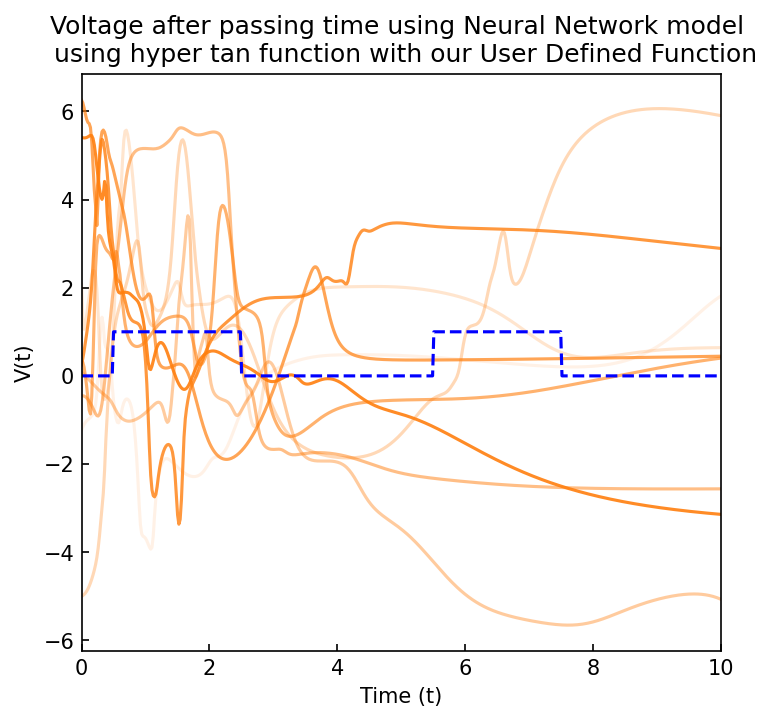

In [60]:
fig, ax = plt.subplots(figsize=(5.5, 5), dpi=150, facecolor='white')
norm = Normalize(vmin=1, vmax=n_pop)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

for i, net in enumerate(pop):
    with torch.no_grad():
        A_t = net(time_steps)
        ax.plot(t_train, A_t, label=f'Pop {i+1}', color='C1', alpha=i/len(pop))

ax.plot(time_steps.numpy(), target_output.numpy(), label='User Defined Function', linestyle='--', color='blue')
ax.set_xlabel('Time (t)')
ax.set_ylabel('V(t)')
ax.set_title('Voltage after passing time using Neural Network model \n using hyper tan function with our User Defined Function')
ax.set_xlim(0,10)
ax.tick_params(direction='in')

#### Loss functions using different optimizers and their plots

In [61]:
# Training function to pass by our optimizers and to save the losses values for the plotting purposes
def train_model(model, input_tensor, optimizer, epochs):
    losses = []
    best_loss = float('inf')
    best_model_state = None  # To store the best model state
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # loss = compute_mse_loss(model, input_tensor, loss_fn)
        loss = compute_sum_difference_loss(model, input_tensor)

        # Track the best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()  # Save the model state
        
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        
        losses.append(loss.item())  # Store the loss value
        
        if epoch % 100 == 0:  # Print loss every 100 epochs
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

    return best_loss, losses, best_model_state

Creating Adam opimizer for the loss function 

In [63]:
model_adam = VoltagePredictor(input_size, hidden_sizes, output_size) 

optimizer = optim.Adam(model_adam.parameters(), lr=0.001)  # Adjust learning rate as needed

n_epochs = 2000  # Set the number of epochs

best_loss_adam, losses_adam, best_model_state = train_model(model_adam, time_steps, optimizer,  n_epochs)
# print(best_model_state) 

Epoch [0/2000], Loss: 1820.3690185546875
Epoch [100/2000], Loss: 150.89097595214844
Epoch [200/2000], Loss: 105.82081604003906
Epoch [300/2000], Loss: 57.776832580566406
Epoch [400/2000], Loss: 44.44041061401367
Epoch [500/2000], Loss: 43.400569915771484
Epoch [600/2000], Loss: 40.2991828918457
Epoch [700/2000], Loss: 41.18616485595703
Epoch [800/2000], Loss: 39.67496871948242
Epoch [900/2000], Loss: 36.29512023925781
Epoch [1000/2000], Loss: 35.38344955444336
Epoch [1100/2000], Loss: 35.942928314208984
Epoch [1200/2000], Loss: 32.01426696777344
Epoch [1300/2000], Loss: 32.02786636352539
Epoch [1400/2000], Loss: 31.551897048950195
Epoch [1500/2000], Loss: 28.985986709594727
Epoch [1600/2000], Loss: 29.903335571289062
Epoch [1700/2000], Loss: 25.762561798095703
Epoch [1800/2000], Loss: 24.46361541748047
Epoch [1900/2000], Loss: 24.30649185180664


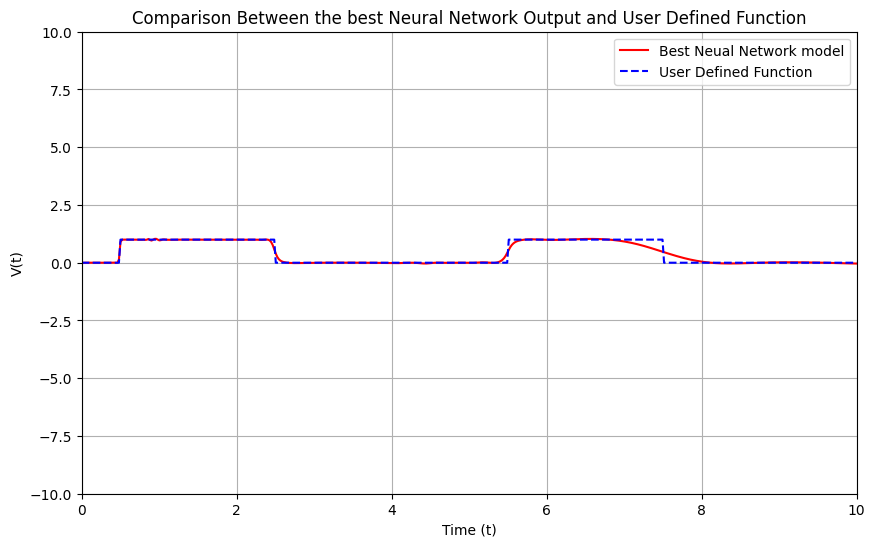

In [64]:
# After training the model and loading the best model state
model_adam.load_state_dict(best_model_state)

# Generate model outputs with the best model
model_output_best = model_adam(t_train_tensor)

# Get the user-defined function outputs for comparison
target_output = user_defined_function(t_train_tensor)

error = torch.abs(model_output_best - target_output)

plt.figure(figsize=(10, 6))
plt.plot(t_train, model_output_best.detach().numpy(), label='Best Neual Network model', color='red')
plt.plot(t_train, target_output.numpy(), label='User Defined Function', linestyle='--', color='blue')
plt.xlabel('Time (t)')
plt.ylabel('V(t)')
plt.title('Comparison Between the best Neural Network Output and User Defined Function')
plt.legend()
plt.grid()
plt.xlim(0, 10)
# plt.ylim(0, max( error.detach().numpy()) + 1)
plt.ylim(-10,10)
plt.show()

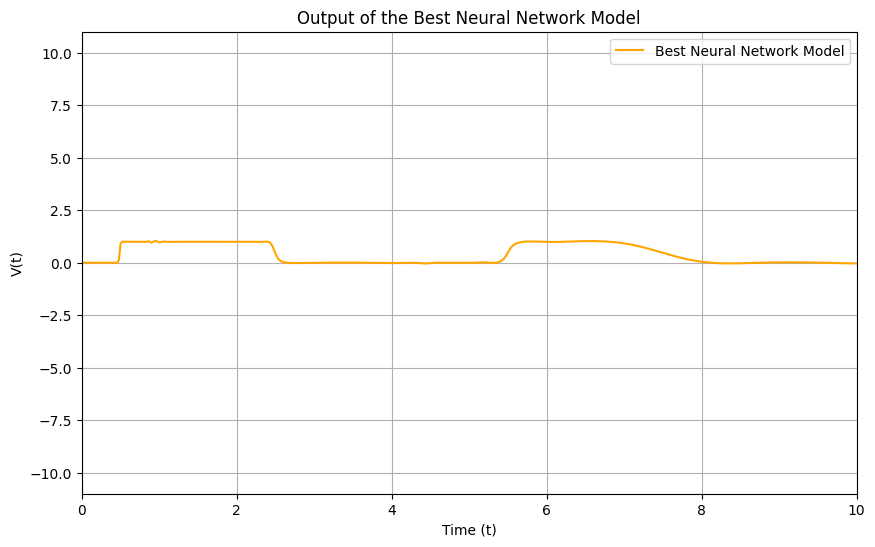

In [65]:
# Plotting only the neural network output
plt.figure(figsize=(10, 6))
plt.plot(time_steps.numpy(), model_output_best.detach().numpy(), label='Best Neural Network Model', color='orange')
plt.xlabel('Time (t)')
plt.ylabel('V(t)')
plt.title('Output of the Best Neural Network Model')
plt.legend()
plt.grid()
plt.xlim(0, 10)
plt.ylim(-11, 11)
plt.show()

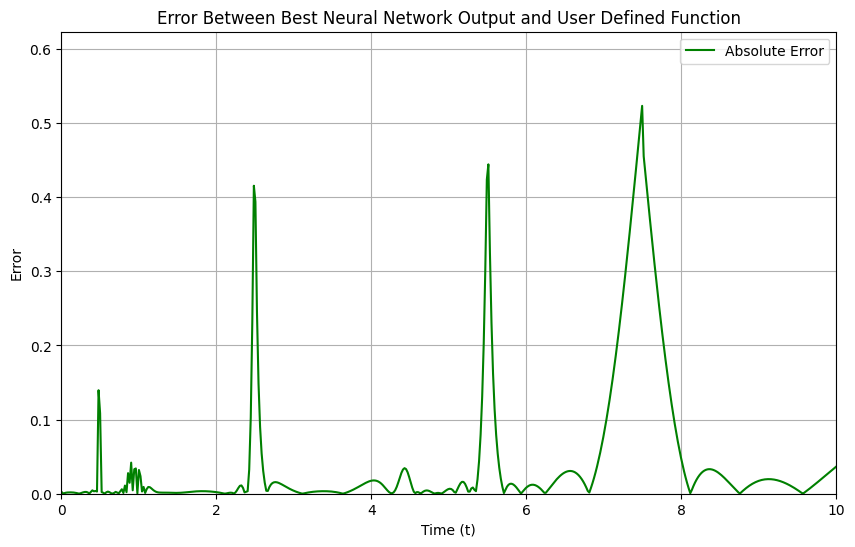

In [66]:
# Plotting the Error
plt.figure(figsize=(10, 6))
plt.plot(t_train, error.detach().numpy(), label='Absolute Error', color='green')
plt.xlabel('Time (t)')
plt.ylabel('Error')
plt.title('Error Between Best Neural Network Output and User Defined Function')
plt.legend()
plt.grid()
plt.xlim(0, 10)
plt.ylim(0, max(error.detach().numpy()) + 0.1)  # Adjust based on maximum error
plt.show()

In [67]:
# Output the best loss
print(f'Best loss achieved: {best_loss_adam}')

Best loss achieved: 21.799453735351562


Creating Stochastic Gradient Descent SGD opimizer for the loss function 

### The equation for \( Q \) can be expressed as:

$$
Q = \int_{t_i}^{t_f} \frac{V^2(t)}{R_M(x)} \, dt
$$

### Where 
$$
R_M(x) = a + b.x
$$

In [87]:
# we can also use the ramdom library to create ramdom numbers
a = np.random.randint(1, 11) # Random value for the constant value a
b = np.random.randint(1, 11) # Random value for the constant value b

# Initial state for x
x0 = 0 

# Define the memristance R(x)
def R(x):
    return a + b * x 

# Define differential equation for dx/dt
def dxdt(x, t, V):
    k = 1  # Proportionality constant
    V_on = 0  # Threshold voltage Von
    return k * (V - V_on)   

def get_x_over_time(model, t_vals, x0):
    V_vals = [model.get_output(t) for t in t_vals]  # Predict V(t)
    x_vals = np.zeros_like(t_vals) 

    # Integrate x using each V value at the corresponding time step
    for i, t in enumerate(t_vals):
        if i == 0:
            x_vals[i] = x0 
        else:
            dt = t_vals[i] - t_vals[i-1]
            V_current = V_vals[i-1]  
            x_vals[i] = x_vals[i-1] + dxdt(x_vals[i-1], t, V_current) * dt  # Simple Euler integration
    
    return x_vals

In [88]:
def integrand(t, model, x0):
    x = get_x_over_time(model, [t], x0)[0]  # Get x for current time t
    V_t = model.get_output(t)  # Get the predicted voltage from the neural network
    R_x = R(x)                  # Get the resistance R at x
    return (V_t ** 2) / R_x     # Return the integrand

def compute_Q(model, x0, t_i, t_f):
    # Lambda used for integration
    integrand_func = lambda t: integrand(t, model, x0)
    
    # Computing the integral 
    Q = quad(integrand_func, t_i, t_f)
    return Q 


In [89]:
# Use the neural network to predict V(t) and integrate dx/dt
def get_x_over_time(model, t_vals, x0):
    V_vals = [model.get_output(t) for t in t_vals]  # Predict V(t)
    x_vals = np.zeros_like(t_vals)  # Initialize array for x values

    # Integrate using each V value at the corresponding time step
    for i, t in enumerate(t_vals):
        if i == 0:
            x_vals[i] = x0  
        else:
            dt = t_vals[i] - t_vals[i-1]
            V_current = V_vals[i-1]  # Use the previous voltage
            x_vals[i] = x_vals[i-1] + dxdt(x_vals[i-1], t, V_current) * dt  # Simple Euler integration
    
    return x_vals  

In [90]:
# This loss function is MSELoss for the equation 
def compute_loss(model, t_i, t_f, n_samples=100):
    # Sample n_samples evenly spaced points in [t_i, t_f]
    t_samples = torch.linspace(t_i, t_f, n_samples).reshape(-1, 1)
    
    # Compute V(t) for these sampled points
    V_samples = model(t_samples)  # Shape: [n_samples, 1]
    
    # Calculate Q for the sampled points
    Q = 0.0
    for i in range(n_samples):
        Q += (V_samples[i] ** 2) / R(t_samples[i].item())  # Use i to index V_samples
    
    # Average Q over the number of samples
    Q /= n_samples
    return Q

In [92]:
# Initialize the model and optimizer
model_Q = VoltagePredictor(input_size, hidden_sizes, output_size)
optimizer_Q = optim.Adam(model_Q.parameters(), lr=0.01)
losses_Q = [] 
Q_s = []
best_loss_Q = float('inf')
best_model_state_Q = None  # To store the best model state

# Set integration limits
t_i = 0
t_f = 10

# Optimization loop
num_epochs = 110  # Number of training epochs
for epoch in range(num_epochs):
    optimizer_Q.zero_grad()  # Zero the gradients
    
    # Compute the integral Q
    Q , _= compute_Q(model_Q, x0, t_i, t_f)
    Q_s.append(Q)
    
    # Create a loss from Q
    loss_Q = compute_loss(model_Q, t_i, t_f)  # You might want to include other loss components
    losses_Q.append(loss_Q.item())
    if loss_Q < best_loss_Q:
            best_loss_Q = loss_Q
            best_model_state_Q = model_Q.state_dict()  # Save the model state
    
    loss_Q.backward()  # Backpropagate the loss
    optimizer_Q.step()  # Update model parameters
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss_Q.item()}, Q: {Q}')

/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_43610/1344104424.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Q = quad(integrand_func, t_i, t_f)


Epoch 0, Loss: 0.08314984291791916, Q: 1.6663660018164208


/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_43610/1344104424.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Q = quad(integrand_func, t_i, t_f)


Epoch 10, Loss: 0.008373093791306019, Q: 0.25805405877390436
Epoch 20, Loss: 0.003164122812449932, Q: 0.08869496616999542
Epoch 30, Loss: 0.0008755023591220379, Q: 0.029447306677771054
Epoch 40, Loss: 0.0003558020980563015, Q: 0.015752148397669783
Epoch 50, Loss: 0.00015702030214015394, Q: 0.0055378090884522745
Epoch 60, Loss: 8.293501741718501e-05, Q: 0.00436483035016575
Epoch 70, Loss: 4.321376763982698e-05, Q: 0.0027061939048360446
Epoch 80, Loss: 2.6395186068839394e-05, Q: 0.00251359547920953
Epoch 90, Loss: 1.7019297956721857e-05, Q: 0.0020671564412064946
Epoch 100, Loss: 1.1322999853291549e-05, Q: 0.0017458738194351551


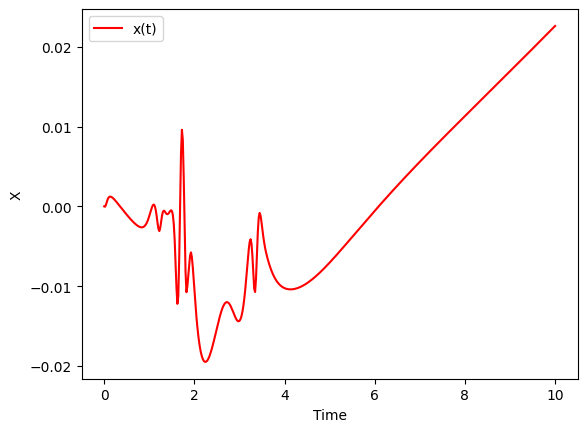

In [93]:
x_values = get_x_over_time(model_Q, t_train, x0)  # Assuming model_Q is your trained model
R_values = R(x_values)

plt.plot(t_train, x_values, label='x(t)', color='red')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.show()

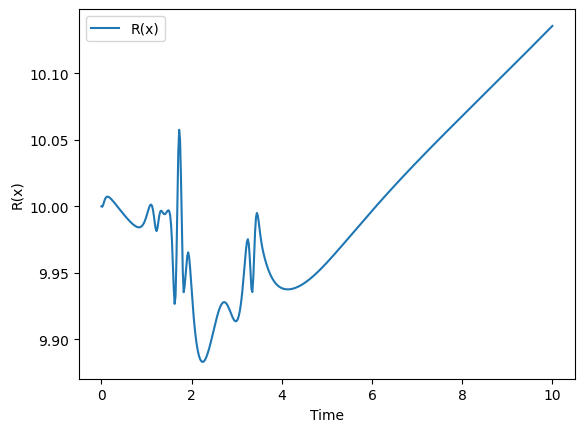

In [94]:
plt.plot(t_train, R_values, label='R(x)')
plt.xlabel('Time')
plt.ylabel('R(x)')
plt.legend()
plt.show()

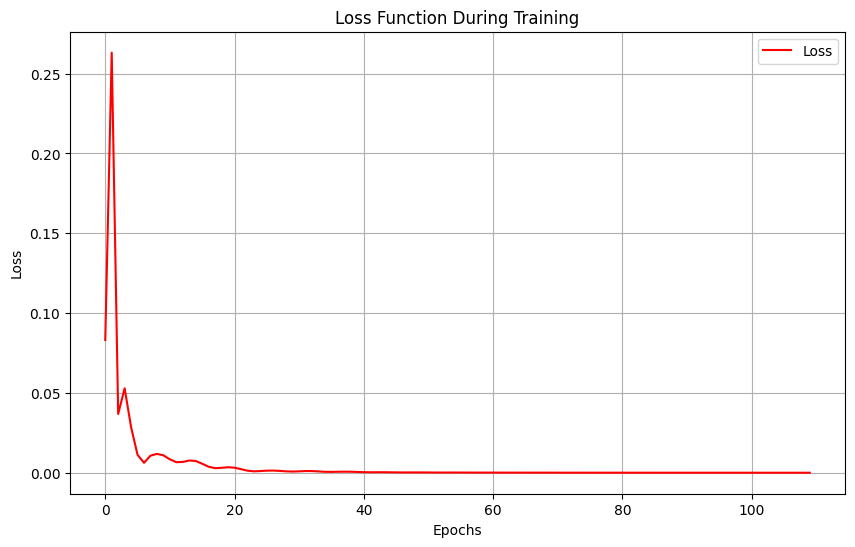

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(losses_Q, label='Loss', color='red')
plt.title('Loss Function During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

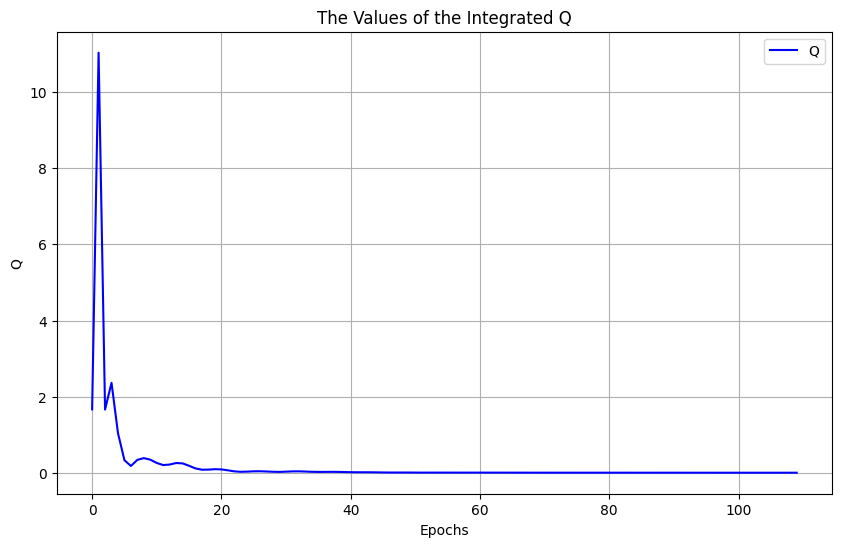

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(Q_s, label='Q', color='blue')
plt.title('The Values of the Integrated Q')
plt.xlabel('Epochs')
plt.ylabel('Q')
plt.legend()
plt.grid()
plt.show()

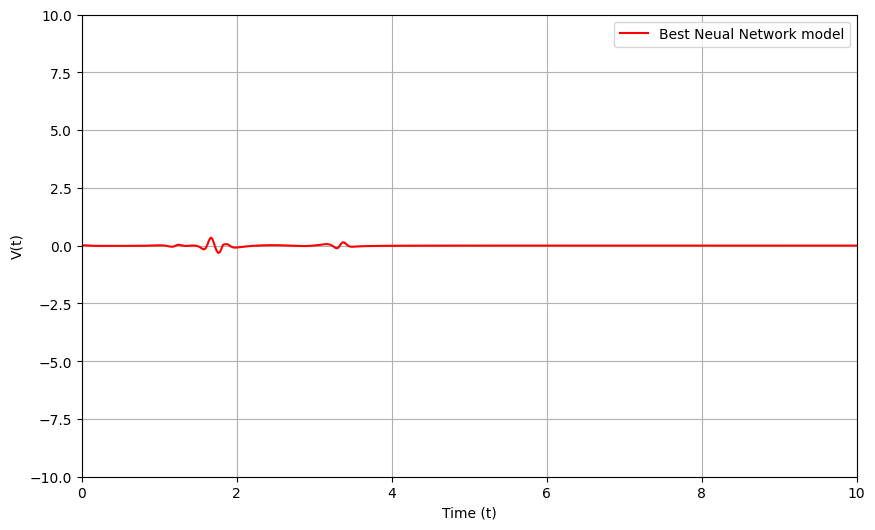

In [97]:
# After training the model and loading the best model state
model_Q.load_state_dict(best_model_state_Q)

# Generate model outputs with the best model
model_output_best_Q = model_Q(t_train_tensor)


plt.figure(figsize=(10, 6))
plt.plot(time_steps, model_output_best_Q.detach().numpy(), label='Best Neual Network model', color='red')
plt.xlabel('Time (t)')
plt.ylabel('V(t)')
# plt.title('Comparison Between the best Neural Network Output and User Defined Function')
plt.legend()
plt.grid()
plt.xlim(0, 10)
# plt.ylim(0, max( error.detach().numpy()) + 1)
plt.ylim(-10,10)
plt.show()